In [2]:
import os
from ms2deepscore.MS2DeepScore import MS2DeepScore
from ms2deepscore.models.load_model import load_model
from matchms.importing.load_from_mgf import load_from_mgf
from ms2deepscore.utils import load_pickled_file


data_folder = "../../../data/pytorch/gnps_21_08_23_min_5_at_5_percent/"
both_mode_folder = os.path.join(data_folder, "trained_models/both_mode_precursor_mz_ionmode_2000_2000_2000_layers_500_embedding_2024_01_31_11_51_10/")

# Spectra
pos_validation_spectra = list(load_from_mgf(os.path.join(data_folder, "training_and_validation_split", "positive_validation_spectra.mgf")))
neg_validation_spectra = list(load_from_mgf(os.path.join(data_folder, "training_and_validation_split", "negative_validation_spectra.mgf")))
pos_training_spectra = list(load_from_mgf(os.path.join(data_folder, "training_and_validation_split", "positive_training_spectra.mgf")))
neg_training_spectra = list(load_from_mgf(os.path.join(data_folder, "training_and_validation_split", "negative_training_spectra.mgf")))

# embeddings
pos_validation_embeddings = load_pickled_file(os.path.join(both_mode_folder, "benchmarking_results", "embeddings", "positive_validation_embeddings.pickle"))
neg_validation_embeddings = load_pickled_file(os.path.join(both_mode_folder, "benchmarking_results", "embeddings", "negative_validation_embeddings.pickle"))
pos_training_embeddings = load_pickled_file(os.path.join(both_mode_folder, "benchmarking_results", "embeddings", "positive_training_embeddings.pickle"))
neg_training_embeddings = load_pickled_file(os.path.join(both_mode_folder, "benchmarking_results", "embeddings", "negative_training_embeddings.pickle"))


In [4]:
import numpy as np
combined_training_embeddings = np.concatenate((pos_training_embeddings, neg_training_embeddings), axis=0)
combined_training_spectra = pos_training_spectra + neg_training_spectra
combined_training_embeddings.shape

(209084, 500)

In [31]:
from ms2deepscore.vector_operations import cosine_similarity_matrix
import numpy as np
from tqdm.notebook import tqdm 
from typing import Optional, Union
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np


def plot_spectra_mirror(spec_top,
                        spec_bottom,
                        ax: Optional[plt.Axes] = None,
                        **spectrum_kws) -> plt.Axes:
    """Mirror plot two MS/MS spectra.

    Code is largely taken from package "spectrum_utils".

    Parameters
    ----------
    spec_top: matchms.Spectrum
        The spectrum to be plotted on the top.
    spec_bottom: matchms.Spectrum
        The spectrum to be plotted on the bottom.
    ax:
        Axes instance on which to plot the spectrum. If None the current Axes
        instance is used.
    spectrum_kws:
        Keyword arguments for `plot_spectrum()`.

    Returns
    -------
    plt.Axes
        The matplotlib Axes instance on which the spectra are plotted.
    """
    if ax is None:
        ax = plt.gca()

    if spectrum_kws is None:
        spectrum_kws = {}
    # Top spectrum.
    plot_spectrum(spec_top, mirror_intensity=False, ax=ax, peak_color="darkblue", **spectrum_kws)
    y_max = ax.get_ylim()[1]

    # Mirrored bottom spectrum.
    plot_spectrum(spec_bottom, mirror_intensity=True, ax=ax, peak_color="teal", **spectrum_kws)
    y_min = ax.get_ylim()[0]
    ax.set_ylim(y_min, y_max)

    ax.axhline(0, color="#9E9E9E", zorder=10)

    # Update axes so that both spectra fit.
    min_mz = max(
        [
            0,
            np.floor(spec_top.peaks.mz[0] / 100 - 1) * 100,
            np.floor(spec_bottom.peaks.mz[0] / 100 - 1) * 100,
        ]
    )
    max_mz = max(
        [
            np.ceil(spec_top.peaks.mz[-1] / 100 + 1) * 100,
            np.ceil(spec_bottom.peaks.mz[-1] / 100 + 1) * 100,
        ]
    )
    ax.set_xlim(min_mz, max_mz)
    ax.yaxis.set_major_locator(mticker.AutoLocator())
    ax.yaxis.set_minor_locator(mticker.AutoMinorLocator())
    ax.yaxis.set_major_formatter(
        mticker.FuncFormatter(lambda x, pos: f"{abs(x):.0%}")
    )

    x_text = 0.04 * (max_mz - min_mz)
    ax.text(x_text, y_max, spec_top.get("ionmode") + " reference", ha="left", va="top", zorder=2, backgroundcolor="white")
    ax.text(x_text, y_min, spec_bottom.get("ionmode")+ " query", ha="left", va="bottom", zorder=2, backgroundcolor="white")
    ax.set_title("Spectrum comparison")
    return ax

def check_not_incorrect_ionmode(spectrum):
    if spectrum.get("ionmode") == "positive":
        if spectrum.get("adduct") == "[M-H]-":
            return False
        return True
    if spectrum.get("ionmode") == "negative":
        if spectrum.get("adduct") =="[M+H]+": 
            return False
    return True 


def library_search(reference_embeddings, reference_spectra, query_embeddings, query_spectra):
    ms2ds_similarity = cosine_similarity_matrix(reference_embeddings, query_embeddings)
    highest_predictions = np.argmax(ms2ds_similarity, axis=0)
    for query_index, reference_index in tqdm(enumerate(highest_predictions)):
        reference_spectrum = reference_spectra[reference_index]
        query_spectrum = query_spectra[query_index]
        if reference_spectrum.get("inchikey")[:14] == query_spectrum.get("inchikey")[:14]:
            if reference_spectrum.get("ionmode") != query_spectrum.get("ionmode"):
                if check_not_incorrect_ionmode(reference_spectrum) and check_not_incorrect_ionmode(query_spectrum):
                    plot_spectra_mirror(reference_spectrum, query_spectrum)
                    plt.show()
                    print(reference_spectrum.get("smiles"))
                    print(reference_spectrum.get("ionmode"))
                    print(query_spectrum.get("ionmode"))
                    print(query_index)
                    print(reference_index)
                    print(query_spectrum.get("adduct"))
                    print(reference_spectrum.get("adduct"))
    return highest_predictions

0it [00:00, ?it/s]

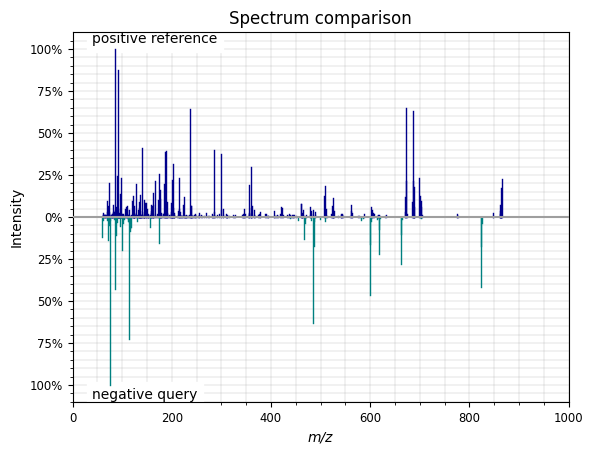

CC1(C)CC[C@]2(C(=O)O[C@@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)CC[C@]3(C)C(=CCC4[C@@]5(C)C[C@H](O)[C@H](O[C@@H]6O[C@H](C(=O)O)[C@@H](O)[C@H](O)[C@H]6O)[C@](C)(C=O)C5CC[C@]43C)[C@@H]2C1
positive
negative
1486
159035
[M-H]-
[M+K]+


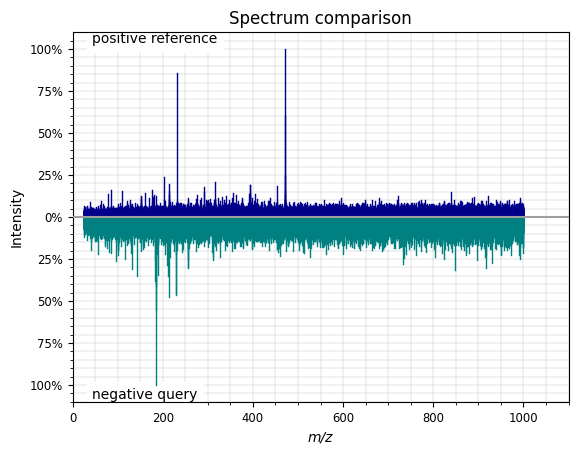

C[C@@H](C1=C[C@@]2(C=C[C@H]3[C@@H]2[C@@H](OC=C3C(=O)OC)O[C@H]4[C@@H]([C@H]([C@@H]([C@H](O4)CO)O)O)O)OC1=O)O
positive
negative
1546
164206
[M-H]-
[M+H]+


array([201895, 202404,  59618, ...,  13690, 182520, 208914])

In [32]:
library_search(combined_training_embeddings, combined_training_spectra, neg_validation_embeddings, neg_validation_spectra)

0it [00:00, ?it/s]

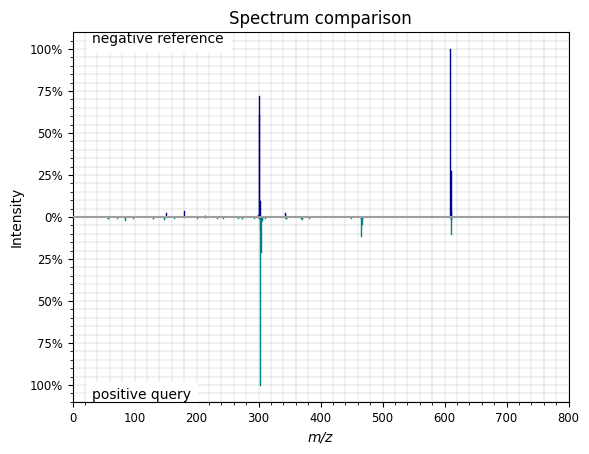

C[C@@H]1O[C@@H](OC[C@H]2O[C@@H](Oc3c(-c4ccc(O)c(O)c4)oc4cc(O)cc(O)c4c3=O)[C@H](O)[C@@H](O)[C@@H]2O)[C@H](O)[C@H](O)[C@H]1O
negative
positive
7181
201967
[M+H]+
[M-H]-


array([ 81595, 101835,  85232, ..., 141331,  80156,  73072])

In [33]:
library_search(combined_training_embeddings, combined_training_spectra, pos_validation_embeddings, pos_validation_spectra)

0it [00:00, ?it/s]

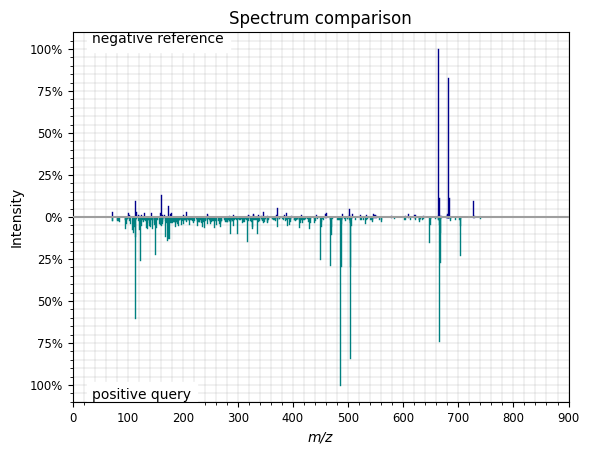

CC(C)(O)CCC(=O)C(C)(O)C1C(O)CC2(C)C3CC=C4C(CC(O)C(OC5OC(CO)C(O)C(O)C5O)C4(C)C)C3(C)C(=O)CC12C
negative
positive
429
1186
[M+NH4]+
[M+FA-H]-


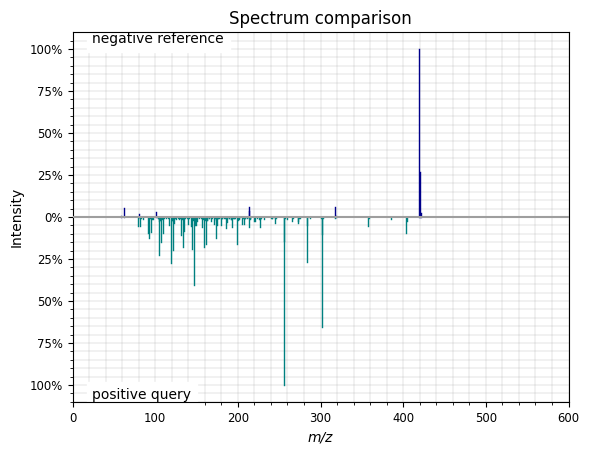

CC(C)CC(=O)OC[C@@]1(O)C[C@@]23CC[C@H]4[C@@](C)(CCC[C@@]4(C)C(=O)O)[C@@H]2CC[C@@H]1C3
negative
positive
551
28593
[M-H2O+H]+
[M-H]-


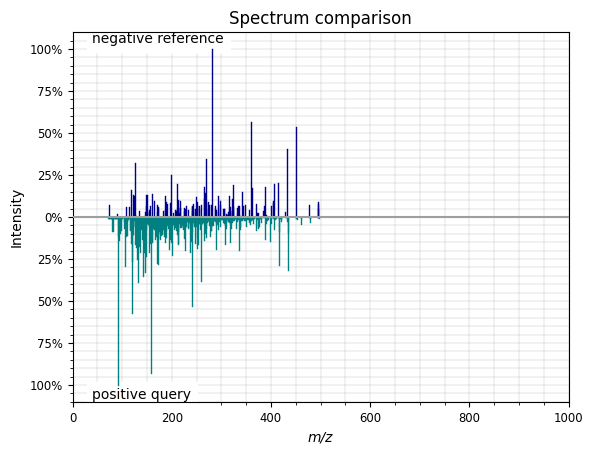

C[C@H]1C/C=C/[C@H]2[C@@H]3O[C@]3(C)[C@@H](C)[C@H]4[C@H](CC5=CC=CC=C5)NC(=O)[C@@]24OC(=O)O/C=C/[C@@](C)(O)C1=O
negative
positive
599
1930
[M+H]+
[M+FA-H]-


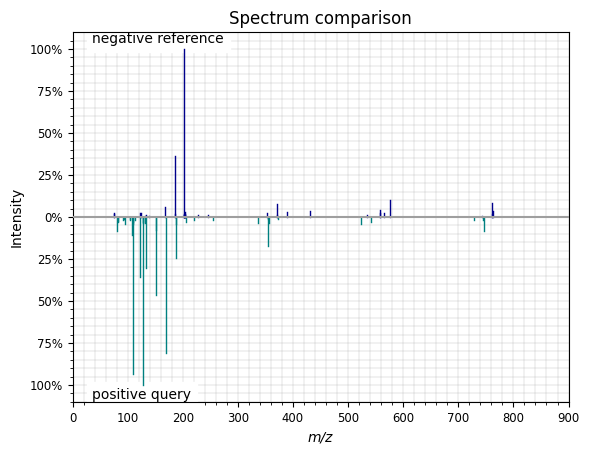

CCCCCC(O)CC(O)CC(=O)OC(CCCCC)CC(O)CC(=O)OC(CCCCC)CC(O)CC(=O)OC(CCCCC)CC(O)CC(O)=O
negative
positive
639
1534
[M-H2O+H]+
[M-H]-


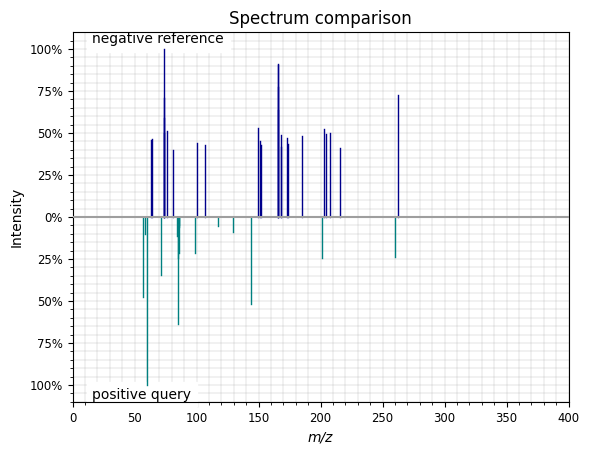

CCCCCC(=O)OC(CC(=O)[O-])C[N+](C)(C)C
negative
positive
1410
7422
[M+H]+
[M-H]-


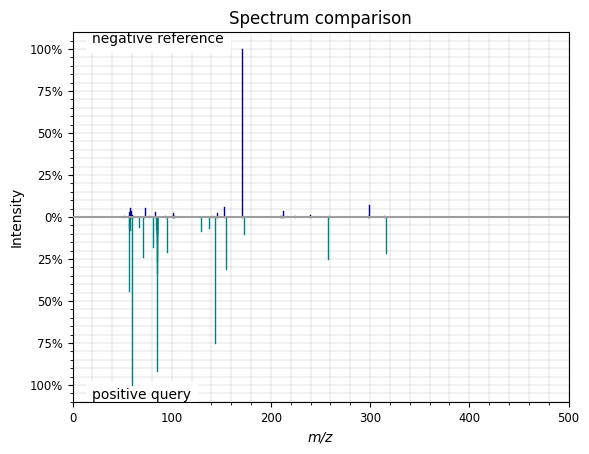

CCCCCCCCCC(=O)OC(CC(=O)[O-])C[N+](C)(C)C
negative
positive
1411
30856
[M+H]+
[M-H]-


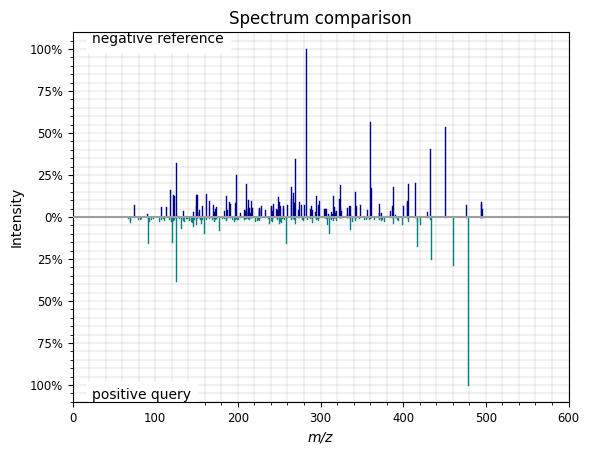

C[C@H]1C/C=C/[C@H]2[C@@H]3O[C@]3(C)[C@@H](C)[C@H]4[C@H](CC5=CC=CC=C5)NC(=O)[C@@]24OC(=O)O/C=C/[C@@](C)(O)C1=O
negative
positive
1487
1930
[M-H2O+H]+
[M+FA-H]-


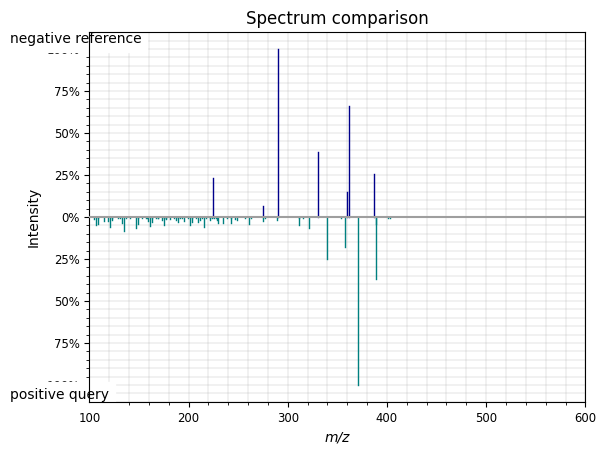

COC(=O)CCC(C)C1CCC2C3CC[C@@H]4C[C@H](O)CC[C@]4(C)C3C[C@H](O)[C@]12C
negative
positive
1492
24881
[M-H2O+H]+
[M-H]-


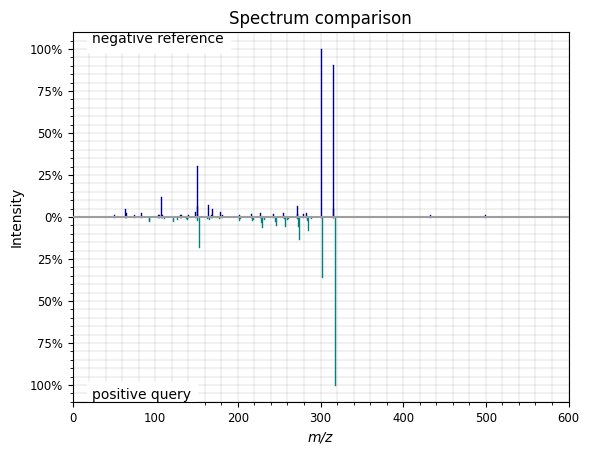

COc1ccc(-c2oc3cc(O)cc(O)c3c(=O)c2O)cc1O
negative
positive
1584
11203
[M+H]+
[M-H]-


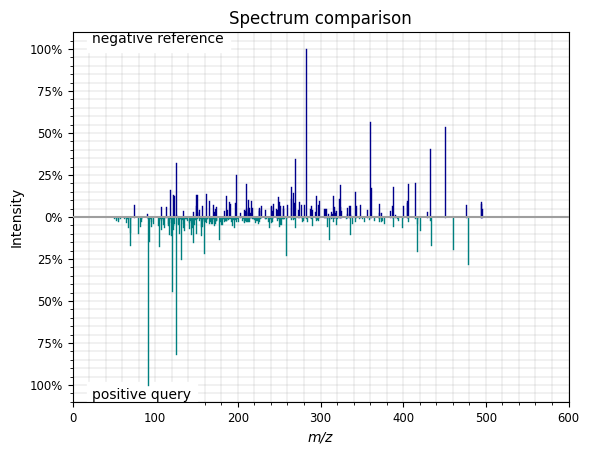

C[C@H]1C/C=C/[C@H]2[C@@H]3O[C@]3(C)[C@@H](C)[C@H]4[C@H](CC5=CC=CC=C5)NC(=O)[C@@]24OC(=O)O/C=C/[C@@](C)(O)C1=O
negative
positive
1630
1930
[M-H2O+H]+
[M+FA-H]-


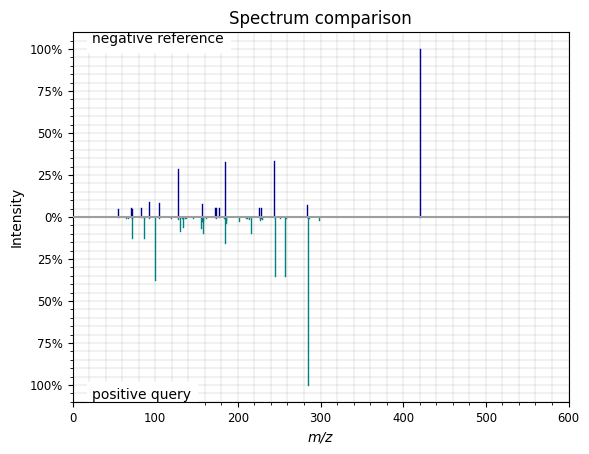

CCN(CC)C(=O)c1cc(=O)n(CC(O)=Nc2ccc3c(c2)OCO3)c2ccccc12
negative
positive
1664
12806
[M+H]+
[M+FA-H]-


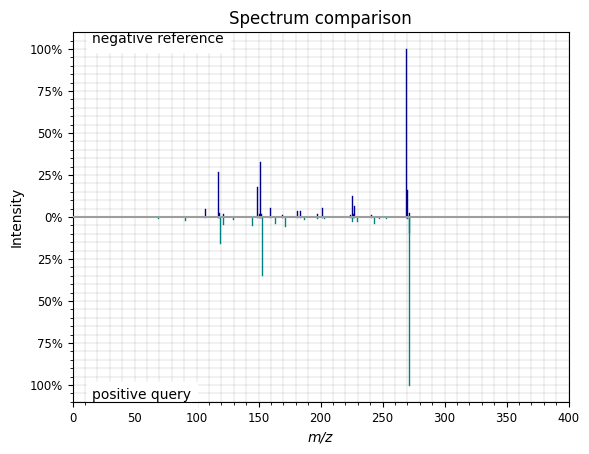

Oc(c3)ccc(c3)C(=C1)Oc(c2)c(c(O)cc(O)2)C(=O)1
negative
positive
2844
21534
[M+H]+
[M-H]-


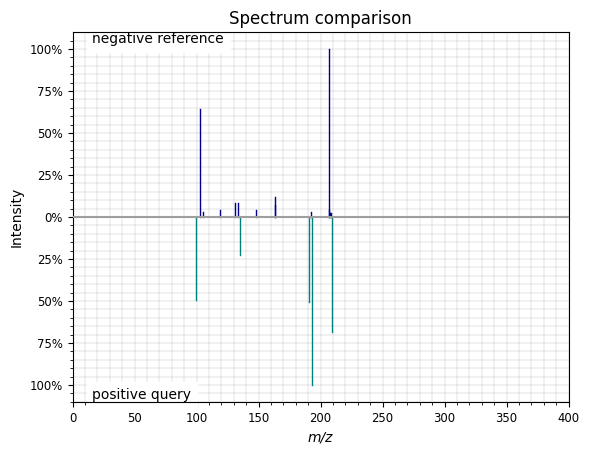

COc(c1)c(OC)cc(C=CC(O)=O)c1
negative
positive
6851
16373
[M+H]+
[M-H]-


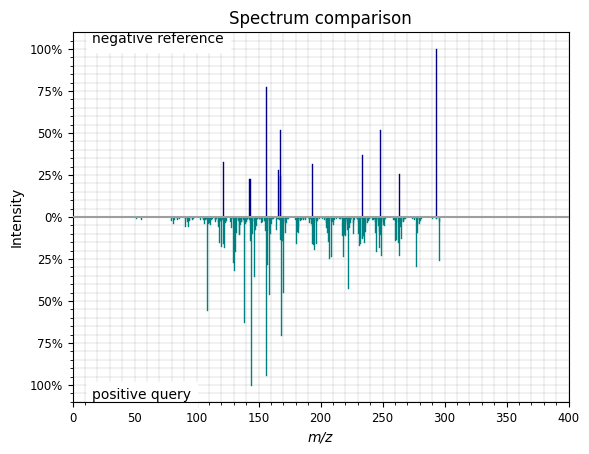

CC=C1CN2C3CC4=C(NC5=CC=CC=C45)C2CC1C3CO
negative
positive
7129
15894
[M+H]+
[M-H]-


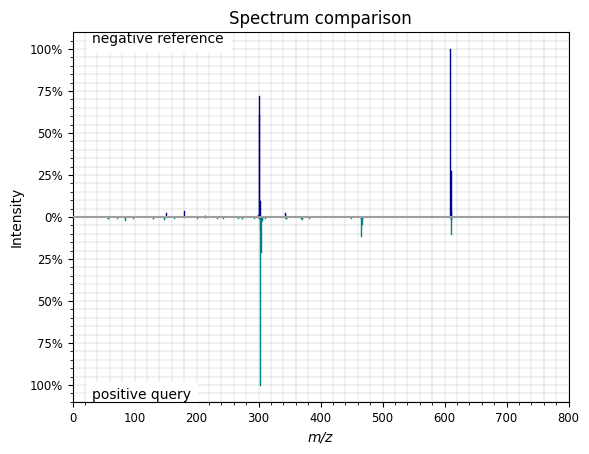

C[C@@H]1O[C@@H](OC[C@H]2O[C@@H](Oc3c(-c4ccc(O)c(O)c4)oc4cc(O)cc(O)c4c3=O)[C@H](O)[C@@H](O)[C@@H]2O)[C@H](O)[C@H](O)[C@H]1O
negative
positive
7181
28001
[M+H]+
[M-H]-


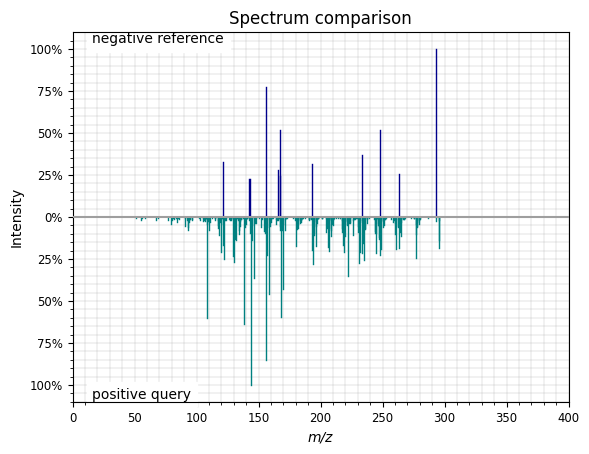

CC=C1CN2C3CC4=C(NC5=CC=CC=C45)C2CC1C3CO
negative
positive
7226
15894
[M+H]+
[M-H]-


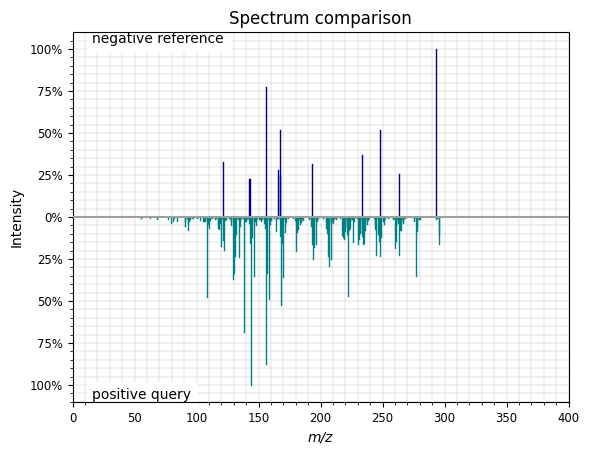

CC=C1CN2C3CC4=C(NC5=CC=CC=C45)C2CC1C3CO
negative
positive
7247
15894
[M+H]+
[M-H]-


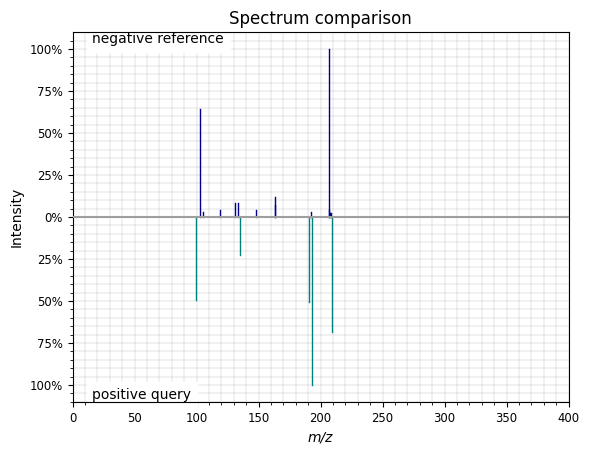

COc(c1)c(OC)cc(C=CC(O)=O)c1
negative
positive
7355
16373
[M+H]+
[M-H]-


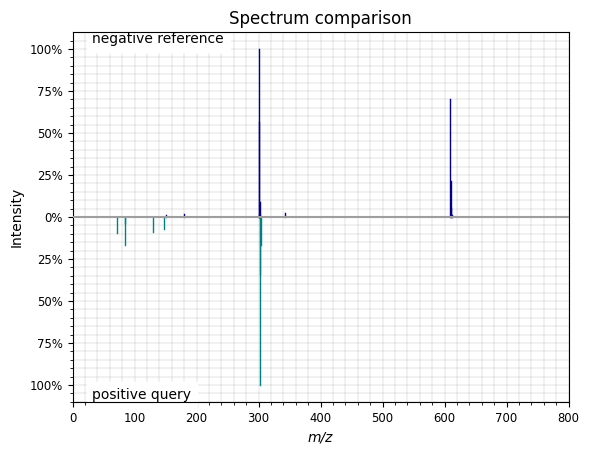

c(c5)(O)cc(c(c52)C(C(O[C@H](O3)[C@@H]([C@H]([C@@H]([C@H]3CO[C@@H]([C@@H]4O)O[C@H]([C@@H]([C@H]4O)O)C)O)O)O)=C(O2)c(c1)ccc(O)c1O)=O)O
negative
positive
7401
21638
[M+H]+
[M-H]-


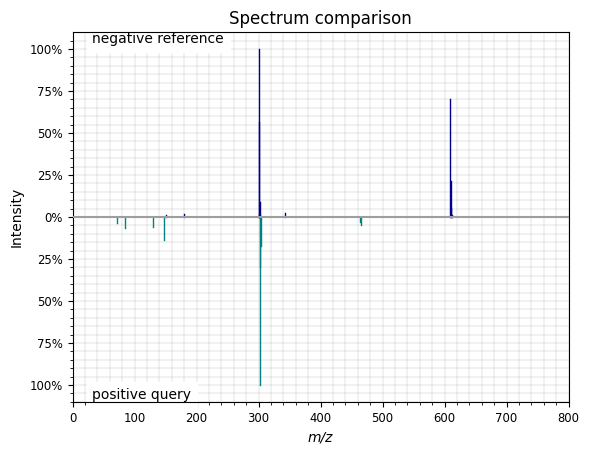

c(c5)(O)cc(c(c52)C(C(O[C@H](O3)[C@@H]([C@H]([C@@H]([C@H]3CO[C@@H]([C@@H]4O)O[C@H]([C@@H]([C@H]4O)O)C)O)O)O)=C(O2)c(c1)ccc(O)c1O)=O)O
negative
positive
7408
21638
[M+H]+
[M-H]-


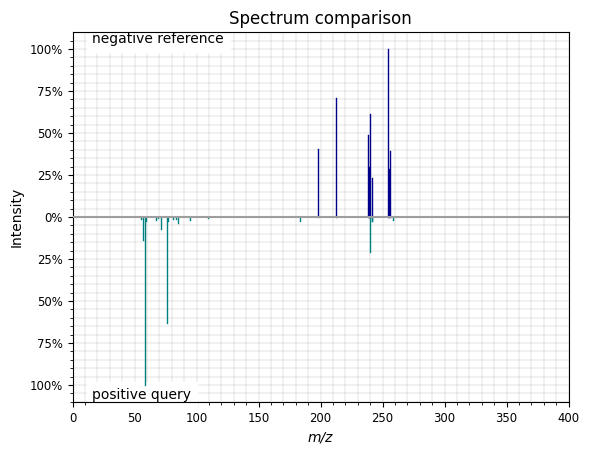

CCCCCCCCCCCC(=O)NCC(C)O
negative
positive
7705
21229
[M+H]+
[M-H]-


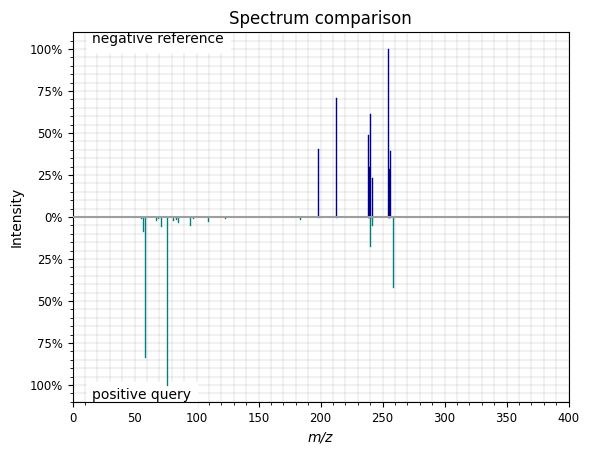

CCCCCCCCCCCC(=O)NCC(C)O
negative
positive
7837
21229
[M+H]+
[M-H]-


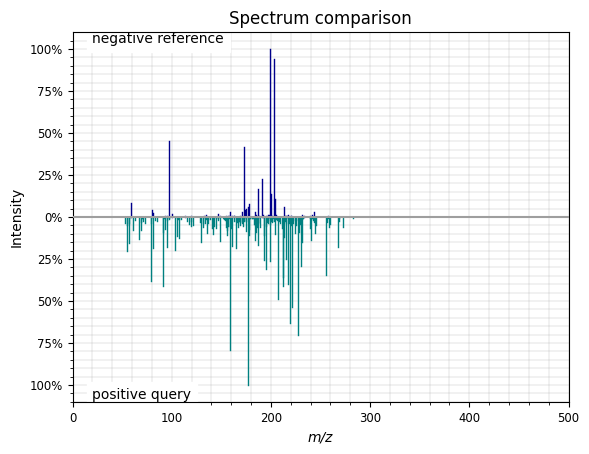

COc1c(C)c2c(c(O)c1C/C=C(\C)C(O)CC(=O)O)C(=O)OC2
negative
positive
8300
26274
[M+NH4]+
[M-H]-


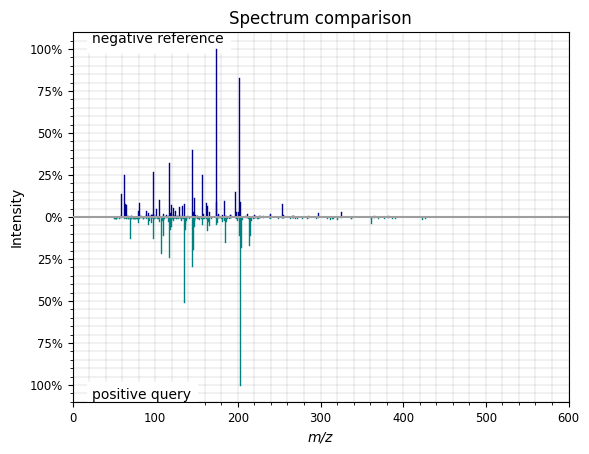

CC1=CC(CC2(C)OC2COc2c3occc3cc3ccc(=O)oc23)OC1=O
negative
positive
8436
26588
[M+K]+
[M-H]-


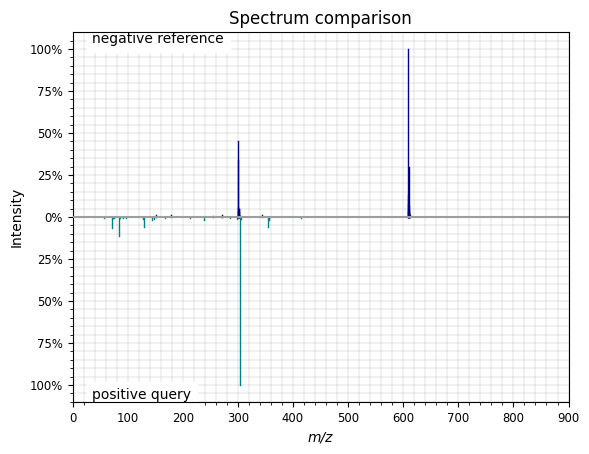

C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)OC[C@@H]2[C@H]([C@@H]([C@H]([C@@H](O2)OC3=C(OC4=CC(=CC(=C4C3=O)O)O)C5=CC(=C(C=C5)O)O)O)O)O)O)O)O
negative
positive
8577
667
[M+H]+
[M-H]-


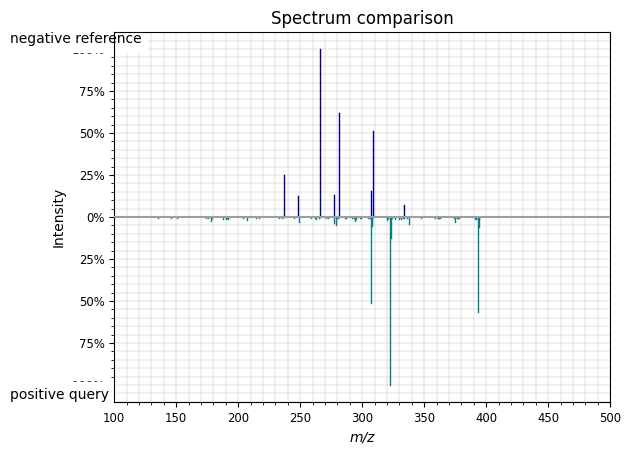

COc1cc2c(cc1O)C1(Cc3ccc4c(c3C1=O)OCO4)N(C)CC2
negative
positive
8790
24741
[M+K]+
[M-H]-


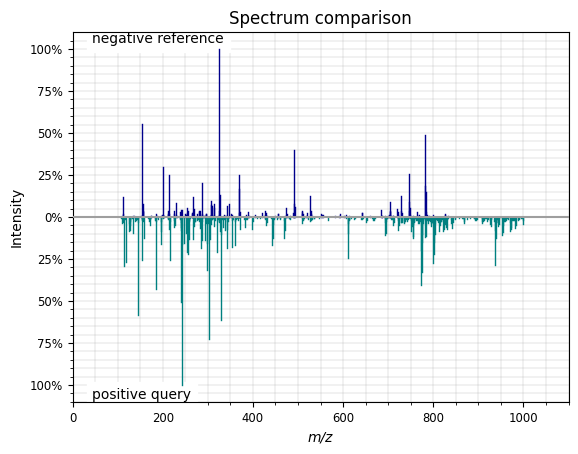

CN[C@H](CC(C)C)C(O)=N[C@H]1C(O)=N[C@@H](CC(=N)O)C(O)=N[C@H]2C(O)=N[C@H]3C(O)=N[C@H](C(O)=N[C@H](C(=O)O)c4cc(O)cc(O)c4-c4cc3ccc4O)[C@H](O)c3ccc(c(Cl)c3)Oc3cc2cc(c3O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O[C@H]2C[C@](C)(N)[C@H](O)[C@H](C)O2)Oc2ccc(cc2Cl)[C@H]1O.Cl
negative
positive
9153
30617
[M+H]+
[M-H]-


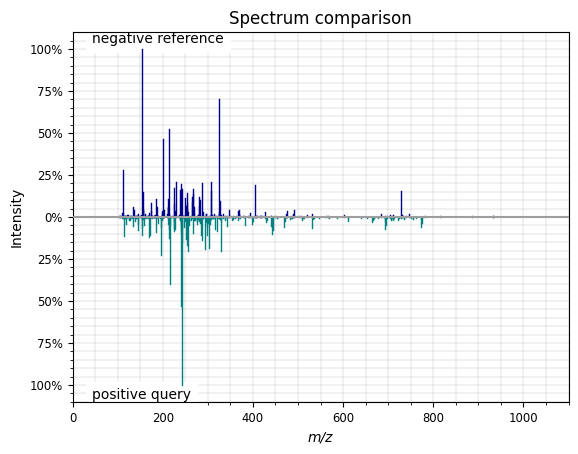

CN[C@H](CC(C)C)C(O)=N[C@H]1C(O)=N[C@@H](CC(=N)O)C(O)=N[C@H]2C(O)=N[C@H]3C(O)=N[C@H](C(O)=N[C@H](C(=O)O)c4cc(O)cc(O)c4-c4cc3ccc4O)[C@H](O)c3ccc(c(Cl)c3)Oc3cc2cc(c3O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O[C@H]2C[C@](C)(N)[C@H](O)[C@H](C)O2)Oc2ccc(cc2Cl)[C@H]1O.Cl
negative
positive
9154
30618
[M+H]+
[M-H]-


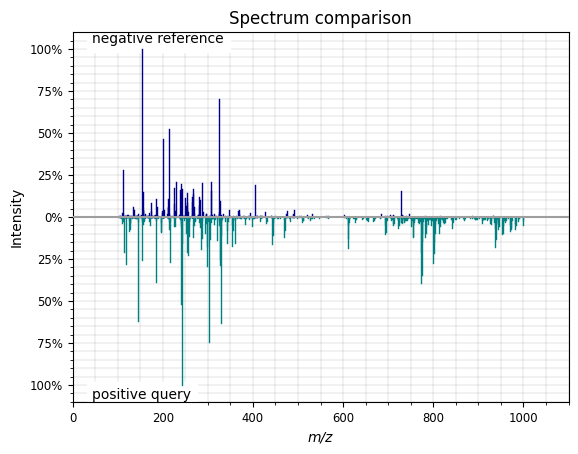

CN[C@H](CC(C)C)C(O)=N[C@H]1C(O)=N[C@@H](CC(=N)O)C(O)=N[C@H]2C(O)=N[C@H]3C(O)=N[C@H](C(O)=N[C@H](C(=O)O)c4cc(O)cc(O)c4-c4cc3ccc4O)[C@H](O)c3ccc(c(Cl)c3)Oc3cc2cc(c3O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O[C@H]2C[C@](C)(N)[C@H](O)[C@H](C)O2)Oc2ccc(cc2Cl)[C@H]1O.Cl
negative
positive
9156
30618
[M+Na]+
[M-H]-


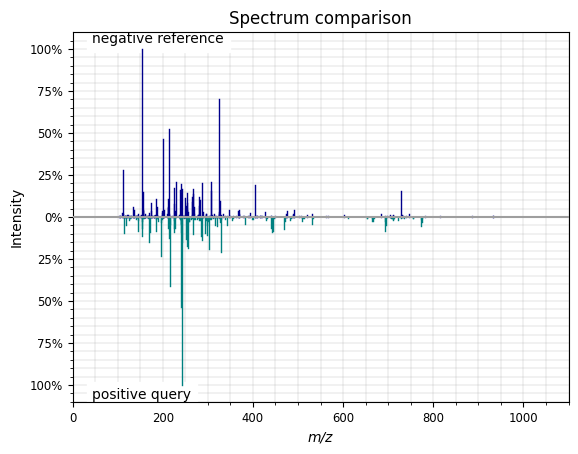

CN[C@H](CC(C)C)C(O)=N[C@H]1C(O)=N[C@@H](CC(=N)O)C(O)=N[C@H]2C(O)=N[C@H]3C(O)=N[C@H](C(O)=N[C@H](C(=O)O)c4cc(O)cc(O)c4-c4cc3ccc4O)[C@H](O)c3ccc(c(Cl)c3)Oc3cc2cc(c3O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O[C@H]2C[C@](C)(N)[C@H](O)[C@H](C)O2)Oc2ccc(cc2Cl)[C@H]1O.Cl
negative
positive
9160
30618
[M+K]+
[M-H]-


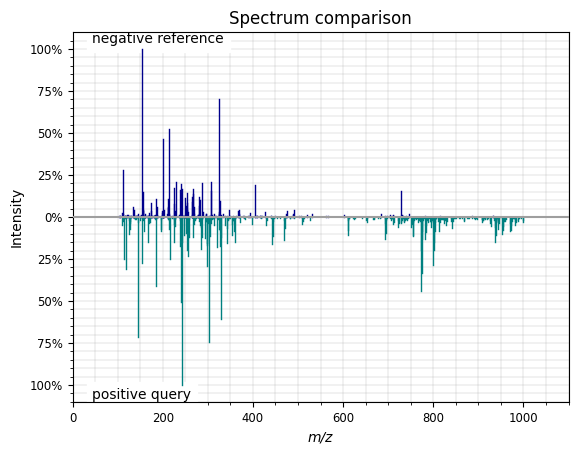

CN[C@H](CC(C)C)C(O)=N[C@H]1C(O)=N[C@@H](CC(=N)O)C(O)=N[C@H]2C(O)=N[C@H]3C(O)=N[C@H](C(O)=N[C@H](C(=O)O)c4cc(O)cc(O)c4-c4cc3ccc4O)[C@H](O)c3ccc(c(Cl)c3)Oc3cc2cc(c3O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O[C@H]2C[C@](C)(N)[C@H](O)[C@H](C)O2)Oc2ccc(cc2Cl)[C@H]1O.Cl
negative
positive
9162
30618
[M+NH4]+
[M-H]-


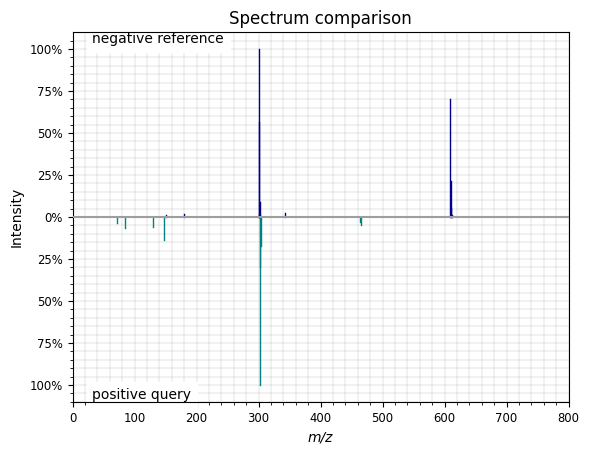

c(c5)(O)cc(c(c52)C(C(O[C@H](O3)[C@@H]([C@H]([C@@H]([C@H]3CO[C@@H]([C@@H]4O)O[C@H]([C@@H]([C@H]4O)O)C)O)O)O)=C(O2)c(c1)ccc(O)c1O)=O)O
negative
positive
9317
21638
[M+H]+
[M-H]-


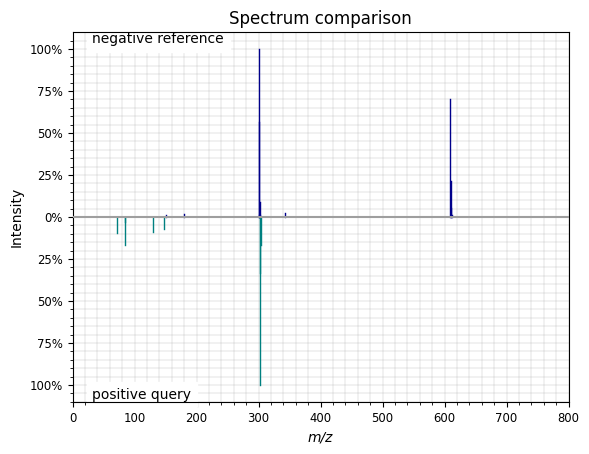

c(c5)(O)cc(c(c52)C(C(O[C@H](O3)[C@@H]([C@H]([C@@H]([C@H]3CO[C@@H]([C@@H]4O)O[C@H]([C@@H]([C@H]4O)O)C)O)O)O)=C(O2)c(c1)ccc(O)c1O)=O)O
negative
positive
9318
21638
[M+H]+
[M-H]-


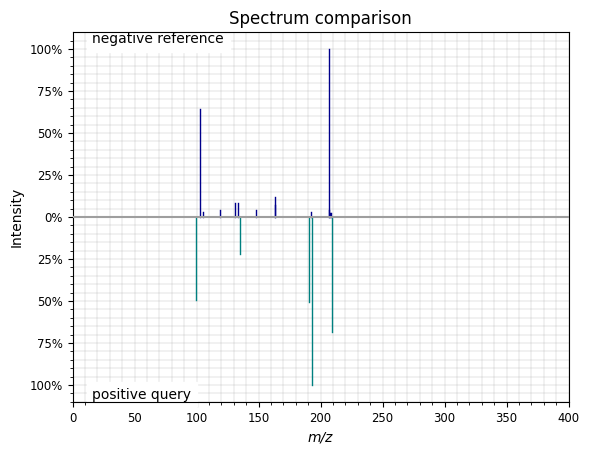

COc(c1)c(OC)cc(C=CC(O)=O)c1
negative
positive
9402
16373
[M+H]+
[M-H]-


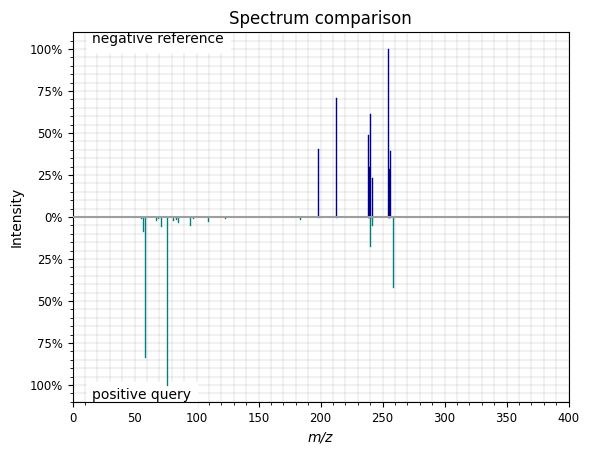

CCCCCCCCCCCC(=O)NCC(C)O
negative
positive
9489
21229
[M+H]+
[M-H]-


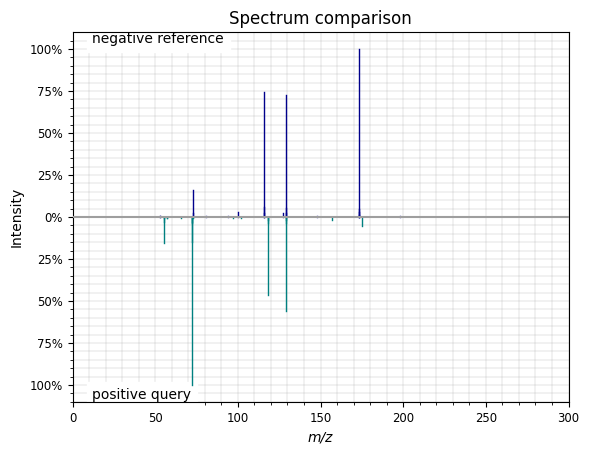

CC(C)[C@@H](C(=O)O)/N=C(\CN)/O
negative
positive
9661
32571
[M+H]+
[M-H]-


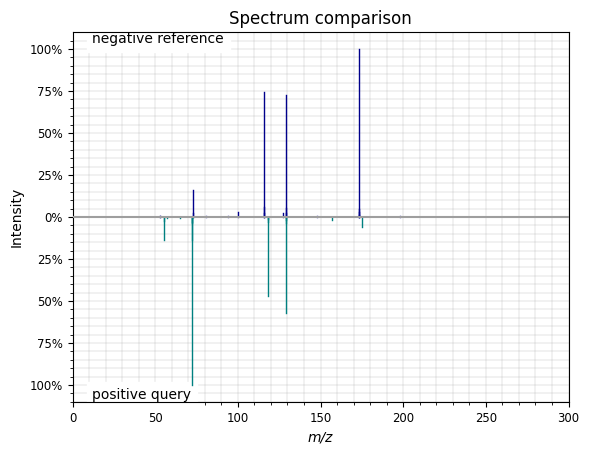

CC(C)[C@@H](C(=O)O)/N=C(\CN)/O
negative
positive
9662
32571
[M+H]+
[M-H]-


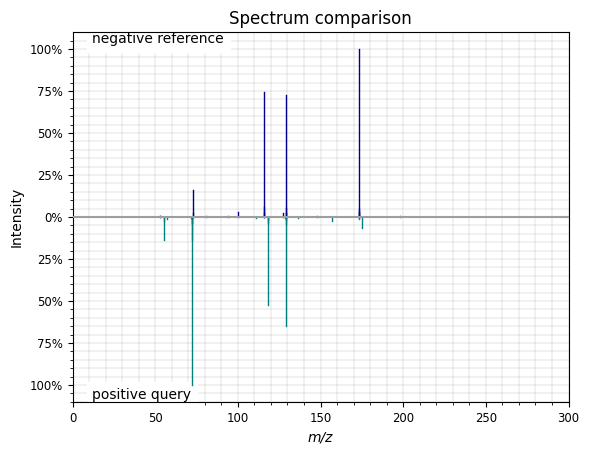

CC(C)[C@@H](C(=O)O)/N=C(\CN)/O
negative
positive
9663
32571
[M+H]+
[M-H]-


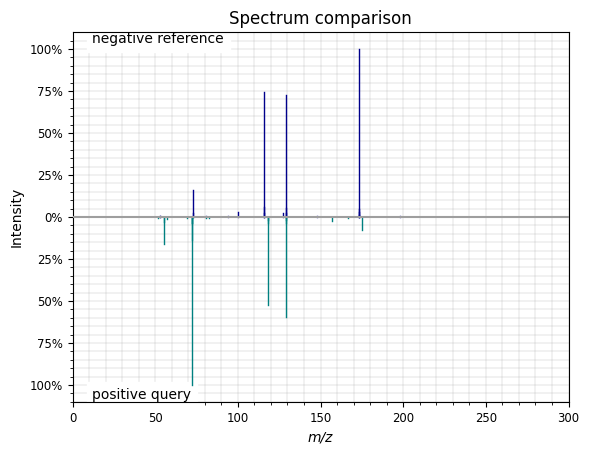

CC(C)[C@@H](C(=O)O)/N=C(\CN)/O
negative
positive
9664
32571
[M+H]+
[M-H]-


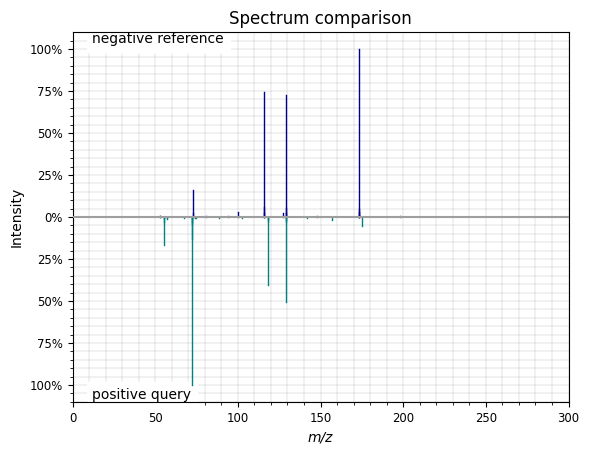

CC(C)[C@@H](C(=O)O)/N=C(\CN)/O
negative
positive
9665
32571
[M+H]+
[M-H]-


array([18515,  2114, 24687, ..., 12908, 10161, 12908])

In [34]:
library_search(neg_training_embeddings, neg_training_spectra, pos_validation_embeddings, pos_validation_spectra)

0it [00:00, ?it/s]

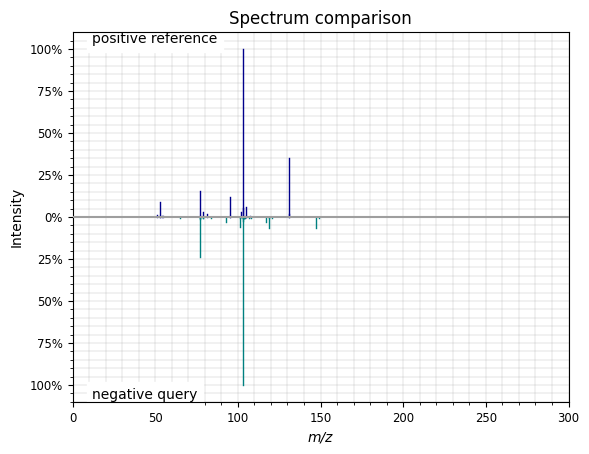

C1=CC=C(C=C1)/C=C/C(=O)O
positive
negative
42
4944
[M-H]-
[M+H]+


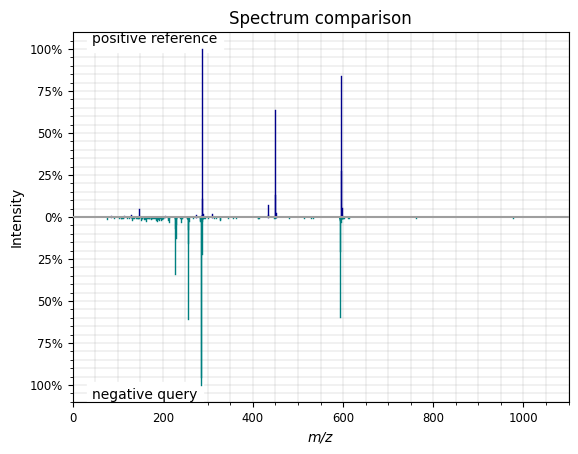

C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)OC[C@@H]2[C@H]([C@@H]([C@H]([C@@H](O2)OC3=C(OC4=CC(=CC(=C4C3=O)O)O)C5=CC=C(C=C5)O)O)O)O)O)O)O
positive
negative
45
5752
[M-H]-
[M+H]+


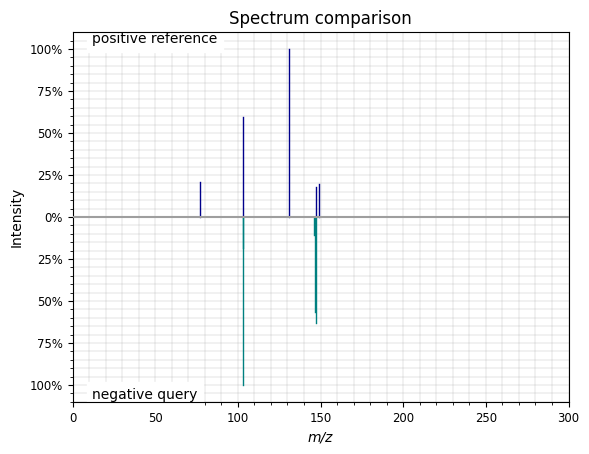

OC(=O)C=CC1=CC=CC=C1
positive
negative
1008
134694
[M-H]-
[M+H]+


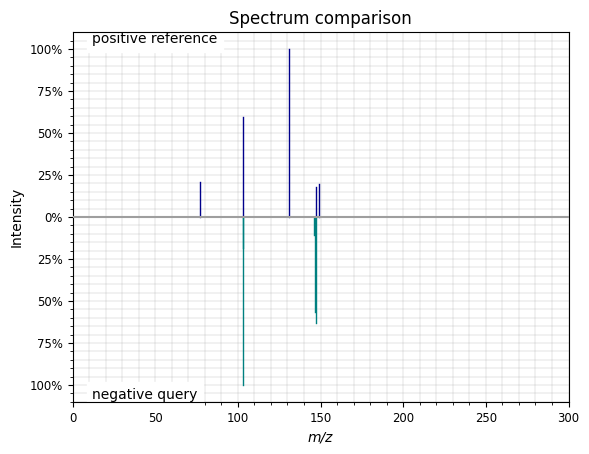

OC(=O)C=CC1=CC=CC=C1
positive
negative
1111
134694
[M-H]-
[M+H]+


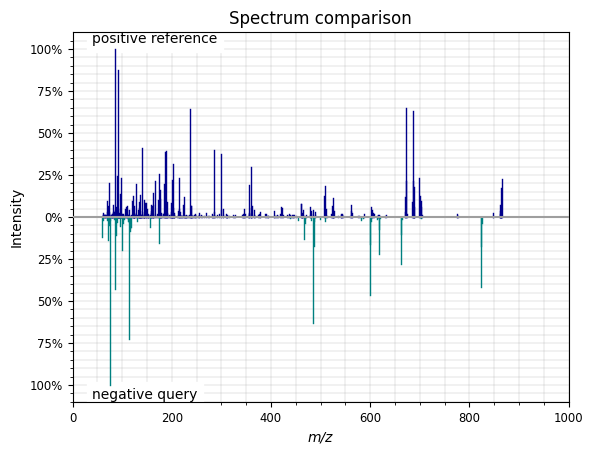

CC1(C)CC[C@]2(C(=O)O[C@@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)CC[C@]3(C)C(=CCC4[C@@]5(C)C[C@H](O)[C@H](O[C@@H]6O[C@H](C(=O)O)[C@@H](O)[C@H](O)[C@H]6O)[C@](C)(C=O)C5CC[C@]43C)[C@@H]2C1
positive
negative
1486
159035
[M-H]-
[M+K]+


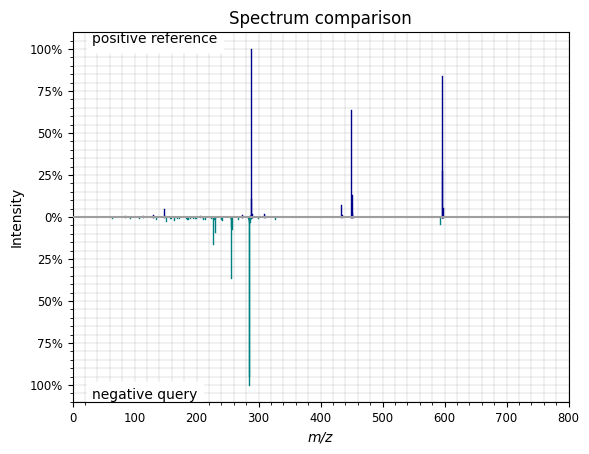

C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)OC[C@@H]2[C@H]([C@@H]([C@H]([C@@H](O2)OC3=C(OC4=CC(=CC(=C4C3=O)O)O)C5=CC=C(C=C5)O)O)O)O)O)O)O
positive
negative
1536
5752
[M-H]-
[M+H]+


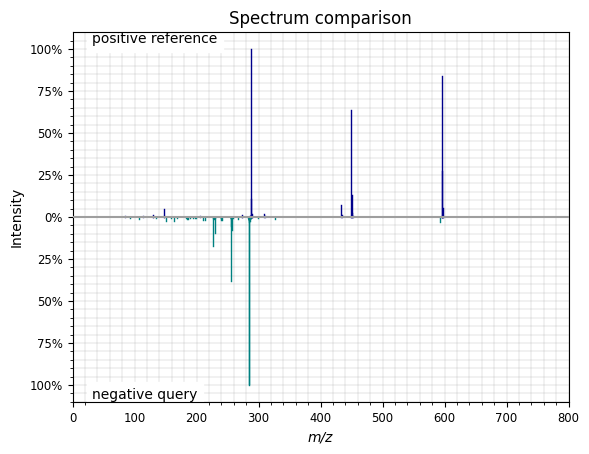

C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)OC[C@@H]2[C@H]([C@@H]([C@H]([C@@H](O2)OC3=C(OC4=CC(=CC(=C4C3=O)O)O)C5=CC=C(C=C5)O)O)O)O)O)O)O
positive
negative
1538
5752
[M-H]-
[M+H]+


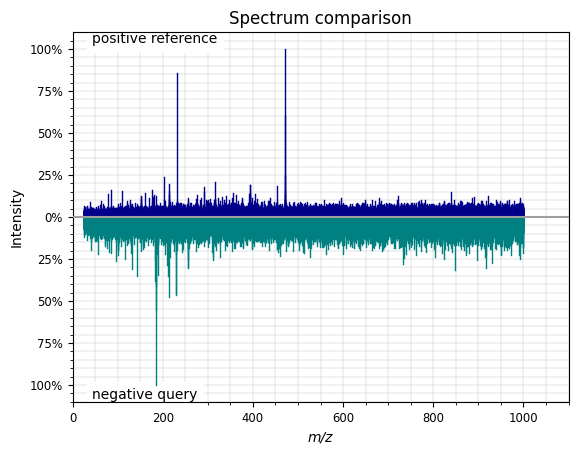

C[C@@H](C1=C[C@@]2(C=C[C@H]3[C@@H]2[C@@H](OC=C3C(=O)OC)O[C@H]4[C@@H]([C@H]([C@@H]([C@H](O4)CO)O)O)O)OC1=O)O
positive
negative
1546
164206
[M-H]-
[M+H]+


array([129279, 125245,  59618, ...,  13690, 109009, 109009])

In [35]:
library_search(pos_training_embeddings, pos_training_spectra, neg_validation_embeddings, neg_validation_spectra)

In [ ]:
def get_unique_inchikeys(spectra):
    for spectrum in spectra:
        inchikey = spectrum.get("inchikey")
        

## Allign two structures

<>:28: DeprecationWarning: invalid escape sequence \C
<>:28: DeprecationWarning: invalid escape sequence \C
C:\Users\jonge094\AppData\Local\Temp\ipykernel_15736\2309487954.py:28: DeprecationWarning: invalid escape sequence \C
  query, template = allign_molecules("COC1=CC=C(\C=C\C(=O)O[C@@H]2[C@@H](O)[C@H](C)O[C@@H](O[C@H]3[C@@H]4\C=C/O[C@@H](O[C@H]5O[C@@H](CO)[C@H](O)[C@@H](O)[C@@H]5O)[C@@H]4[C@@]6(CO)O[C@@H]36)[C@@H]2OC(C)=O)C=C1",


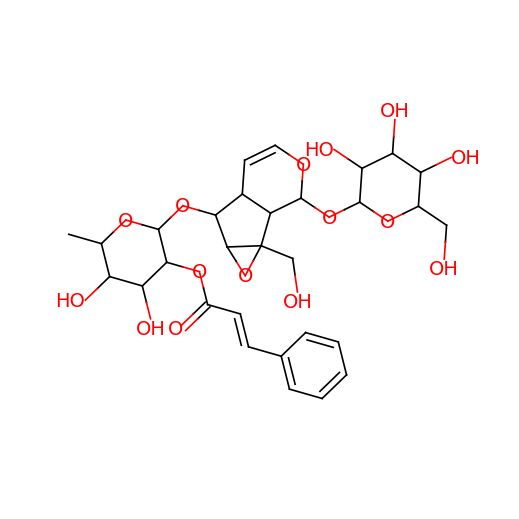

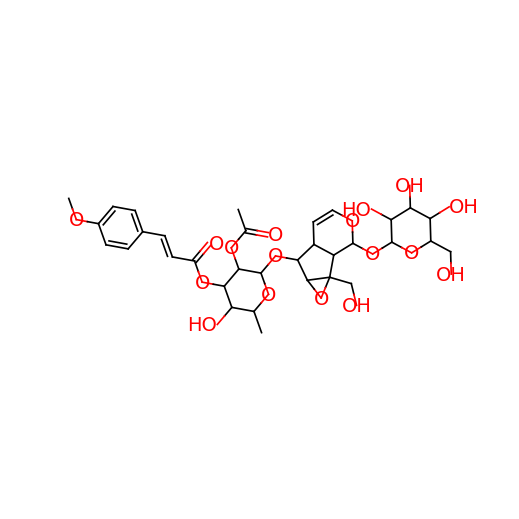

In [66]:
from rdkit.Chem import rdFMCS
from rdkit.Chem import AllChem
def allign_molecules(smiles_1, smiles_2):
    template = Chem.MolFromSmiles(smiles_1)
    query = Chem.MolFromSmiles(smiles_2)
    Chem.RemoveStereochemistry(template)
    Chem.RemoveStereochemistry(query)

    AllChem.Compute2DCoords(query)
    AllChem.Compute2DCoords(template)
    
    mcs = rdFMCS.FindMCS([template, query])
    patt = Chem.MolFromSmarts(mcs.smartsString)
    
    query_match = query.GetSubstructMatch(patt)
    template_match = template.GetSubstructMatch(patt)
    
    rms = AllChem.AlignMol(query, template, atomMap=list(zip(query_match,template_match)))
    # Draw molecules without highlighting the overlap
    Draw.MolToMPL(query, ax=ax, size=(200, 200))
    plt.axis("off")
    plt.show()
    Draw.MolToMPL(template, ax=ax, size=(200, 200))
    plt.axis("off")
    plt.show()
    return query, template

query, template = allign_molecules("COC1=CC=C(\C=C\C(=O)O[C@@H]2[C@@H](O)[C@H](C)O[C@@H](O[C@H]3[C@@H]4\C=C/O[C@@H](O[C@H]5O[C@@H](CO)[C@H](O)[C@@H](O)[C@@H]5O)[C@@H]4[C@@]6(CO)O[C@@H]36)[C@@H]2OC(C)=O)C=C1", 
                 "C[C@@H]1O[C@@H](O[C@H]2[C@@H]3C=CO[C@@H](O[C@@H]4O[C@H](CO)[C@@H](O)[C@H](O)[C@H]4O)[C@@H]3[C@@]3(CO)O[C@@H]23)[C@H](OC(=O)/C=C/c2ccccc2)[C@H](O)[C@H]1O")

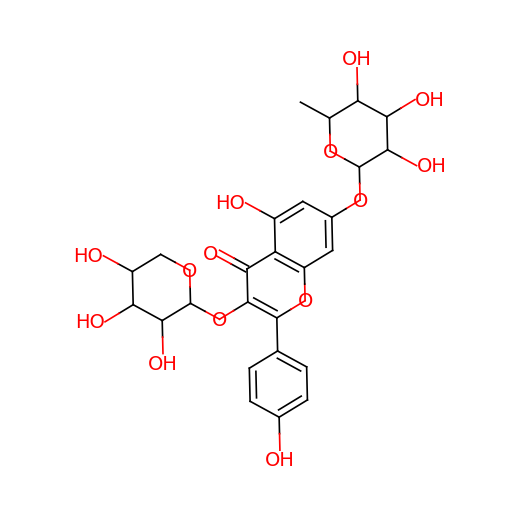

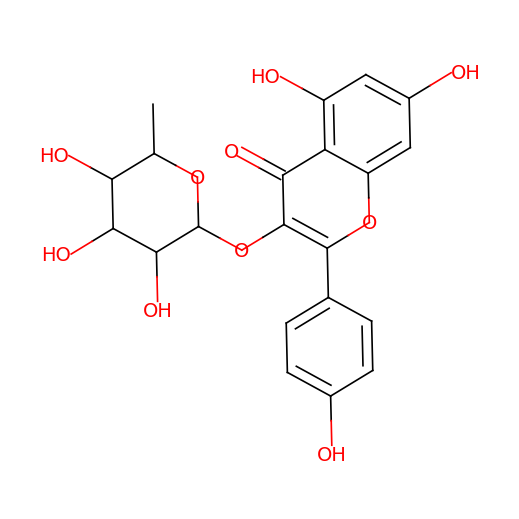

In [47]:
allign_molecules("CC1C(C(C(C(O1)OC2=C(OC3=CC(=CC(=C3C2=O)O)O)C4=CC=C(C=C4)O)O)O)O", 
                 "CC1OC(OC2=CC3=C(C(=O)C(OC4OCC(O)C(O)C4O)=C(O3)C5=CC=C(O)C=C5)C(O)=C2)C(O)C(O)C1O")

<>:1: DeprecationWarning: invalid escape sequence \C
<>:2: DeprecationWarning: invalid escape sequence \C
<>:1: DeprecationWarning: invalid escape sequence \C
<>:2: DeprecationWarning: invalid escape sequence \C
C:\Users\jonge094\AppData\Local\Temp\ipykernel_15736\898902550.py:1: DeprecationWarning: invalid escape sequence \C
  allign_molecules("CCCCCCCCCCCCCCCCC(=O)OC[C@H](COP(=O)([O-])OCC[N+](C)(C)C)OC(=O)CCC/C=C\C/C=C\C/C=C\C/C=C\CCCCC",
C:\Users\jonge094\AppData\Local\Temp\ipykernel_15736\898902550.py:2: DeprecationWarning: invalid escape sequence \C
  "CCCCC\C=C/C\C=C/CCCCCCCC(=O)OCC(COP([O-])(=O)OCC[N+](C)(C)C)OC(=O)CCCCC\C=C/C\C=C/C\C=C/C\C=C/C\C=C/CC")


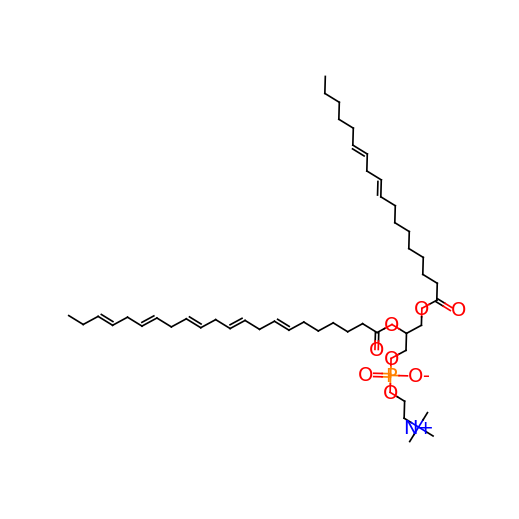

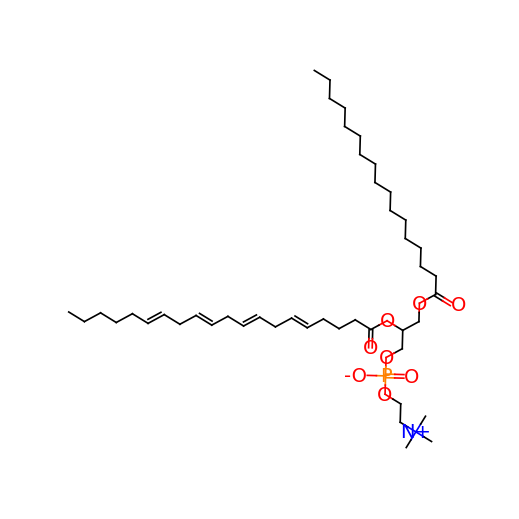

(<rdkit.Chem.rdchem.Mol at 0x2b971f4ec10>,
 <rdkit.Chem.rdchem.Mol at 0x2b97245d5f0>)

In [72]:
allign_molecules("CCCCCCCCCCCCCCCCC(=O)OC[C@H](COP(=O)([O-])OCC[N+](C)(C)C)OC(=O)CCC/C=C\C/C=C\C/C=C\C/C=C\CCCCC",
"CCCCC\C=C/C\C=C/CCCCCCCC(=O)OCC(COP([O-])(=O)OCC[N+](C)(C)C)OC(=O)CCCCC\C=C/C\C=C/C\C=C/C\C=C/C\C=C/CC")